## Regression with a Flood Prediction Dataset 洪水預測
- 目標是根據各種因素預測某個地區發生洪水的機率。
- 洪水檢測是指識別、監控特定區域是否有洪水或可能發生洪水並向當局或個人發出警報的過程。它涉及使用各種技術和方法來檢測、預測和減輕洪水的影響。

### 評估
- 洪水發生的機率值 (FloodProbability) 
- 使用 R2 分數對提交的內容進行評估。

### 特徵定義
- MonsoonIntensity: 季風強度
- TopographyDrainage: 地形排水
- RiverManagement: 河流管理
- Deforestation: 森林破壞
- Urbanization: 都市化程度
- ClimateChange: 氣候變化
- DamsQuality: 水壩品質
- Siltation: 泥沙淤積
- AgriculturalPractices: 農業實踐
- Encroachments: 土地侵占
- IneffectiveDisasterPreparedness: 災害準備不足
- DrainageSystems: 排水系統
- CoastalVulnerability: 海岸脆弱性
- Landslides: 山崩情況
- Watersheds: 水域集水區
- DeterioratingInfrastructure: 基礎設施惡化
- PopulationScore: 人口密度指數
- WetlandLoss: 濕地損失
- InadequatePlanning: 計畫不足
- PoliticalFactors: 政治因素
- FloodProbability: 洪水發生機率

In [67]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from pandas_summary import DataFrameSummary

from sklearn.model_selection import train_test_split, cross_val_score, RepeatedStratifiedKFold, RandomizedSearchCV
from sklearn.ensemble import VotingClassifier, VotingRegressor
from sklearn.preprocessing import LabelEncoder, MinMaxScaler , StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score, make_scorer
from scipy.stats import randint, uniform # 离散的隨機整數, 連續均勻分布的隨機變數

import warnings
warnings.simplefilter("ignore")

plt.rc('font', family = 'Microsoft JhengHei')

#### 載入資料集

In [68]:
df_train = pd.read_csv('./data/Regression with a Flood Prediction Dataset/train.csv')
df_test = pd.read_csv('./data/Regression with a Flood Prediction Dataset/test.csv')

#### 建構新特徵

In [69]:
df_train.drop("id", axis = 1, inplace = True)
df_test.drop("id", axis = 1, inplace = True)

# 新列名的字典對應
new_columns = {
    'MonsoonIntensity': '季風強度',
    'TopographyDrainage': '地形排水',
    'RiverManagement': '河川管理',
    'Deforestation': '森林砍伐',
    'Urbanization': '都市化',
    'ClimateChange': '氣候變遷',
    'DamsQuality': '大壩質量',
    'Siltation': '淤積',
    'AgriculturalPractices': '農業實踐',
    'Encroachments': '侵害',
    'IneffectiveDisasterPreparedness': '災難準備不力',
    'DrainageSystems': '排水系統',
    'CoastalVulnerability': '海岸脆弱性',
    'Landslides': '山崩',
    'Watersheds': '分水嶺',
    'DeterioratingInfrastructure': '基礎設施惡化',
    'PopulationScore': '人口分數',
    'WetlandLoss': '濕地損失',
    'InadequatePlanning': '規劃不充分',
    'PoliticalFactors': '政治因素',
    'FloodProbability': '洪水機率'
}

# 使用 rename 方法進行批量更改
df_train = df_train.rename(columns = new_columns)
df_test = df_test.rename(columns = new_columns)

df_train.head(5)

,季風強度,地形排水,河川管理,森林砍伐,都市化,氣候變遷,大壩質量,淤積,農業實踐,侵害,...,排水系統,海岸脆弱性,山崩,分水嶺,基礎設施惡化,人口分數,濕地損失,規劃不充分,政治因素,洪水機率
0,5,8,5,8,6,4,4,3,3,4,...,5,3,3,5,4,7,5,7,3,0.445
1,6,7,4,4,8,8,3,5,4,6,...,7,2,0,3,5,3,3,4,3,0.450
2,6,5,6,7,3,7,1,5,4,5,...,7,3,7,5,6,8,2,3,3,0.530
3,3,4,6,5,4,8,4,7,6,8,...,2,4,7,4,4,6,5,7,5,0.535
4,5,3,2,6,4,4,3,3,3,3,...,2,2,6,6,4,1,2,3,5,0.415


In [70]:
# 創建摘要
feature_numerical = [feature for feature in df_train.columns if df_train[feature].dtypes != 'O']
df_summary = DataFrameSummary(df_train[feature_numerical])

# 顯示摘要統計信息
df_summary.summary()

,季風強度,地形排水,河川管理,森林砍伐,都市化,氣候變遷,大壩質量,淤積,農業實踐,侵害,...,排水系統,海岸脆弱性,山崩,分水嶺,基礎設施惡化,人口分數,濕地損失,規劃不充分,政治因素,洪水機率
count,1117957.0,1117957.0,1117957.0,1117957.0,1117957.0,1117957.0,1117957.0,1117957.0,1117957.0,1117957.0,...,1117957.0,1117957.0,1117957.0,1117957.0,1117957.0,1117957.0,1117957.0,1117957.0,1117957.0,1117957.0
mean,4.92145,4.926671,4.955322,4.94224,4.942517,4.934093,4.955878,4.927791,4.942619,4.94923,...,4.946893,4.953999,4.931376,4.929032,4.925907,4.92752,4.950859,4.940587,4.939004,0.50448
std,2.056387,2.093879,2.072186,2.051689,2.083391,2.057742,2.083063,2.065992,2.068545,2.083324,...,2.072333,2.088899,2.078287,2.082395,2.064813,2.074176,2.068696,2.081123,2.09035,0.051026
min,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.285
25%,3.0,3.0,4.0,4.0,3.0,3.0,4.0,3.0,3.0,4.0,...,4.0,3.0,3.0,3.0,3.0,3.0,4.0,3.0,3.0,0.47
50%,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,...,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,0.505
75%,6.0,6.0,6.0,6.0,6.0,6.0,6.0,6.0,6.0,6.0,...,6.0,6.0,6.0,6.0,6.0,6.0,6.0,6.0,6.0,0.54
max,16.0,18.0,16.0,17.0,17.0,17.0,16.0,16.0,16.0,18.0,...,17.0,17.0,16.0,16.0,17.0,18.0,19.0,16.0,16.0,0.725
counts,1117957,1117957,1117957,1117957,1117957,1117957,1117957,1117957,1117957,1117957,...,1117957,1117957,1117957,1117957,1117957,1117957,1117957,1117957,1117957,1117957
uniques,17,19,17,18,18,18,17,17,17,19,...,18,18,17,17,18,19,20,17,17,83


#### 異常值檢查
- 所有特徵均有超出最大值的異常值點, 判斷這些條件均有可能發生, 因此不移除

In [71]:
# # feature_numerical 取得數值型特徵
# feature_numerical = [feature for feature in df_train.columns if df_train[feature].dtypes != 'O']

# # Boxplot
# fig, axes = plt.subplots(7,3)
# sns.set_theme(rc = {'figure.figsize' : (20, 15)})
# row, col  = 0, 0
# while row < 7:
#     for feature in feature_numerical:
#         sns.boxplot(x = feature, data = df_train, ax = axes[row, col], color = '#047794')
#         col = col + 1
#         if col == 3:
#             row = row + 1
#             col = 0
# plt.tight_layout(h_pad = 3)

#### EDA - 數值特徵分析

- 觀察預測目標

<Axes: xlabel='洪水機率', ylabel='Count'>

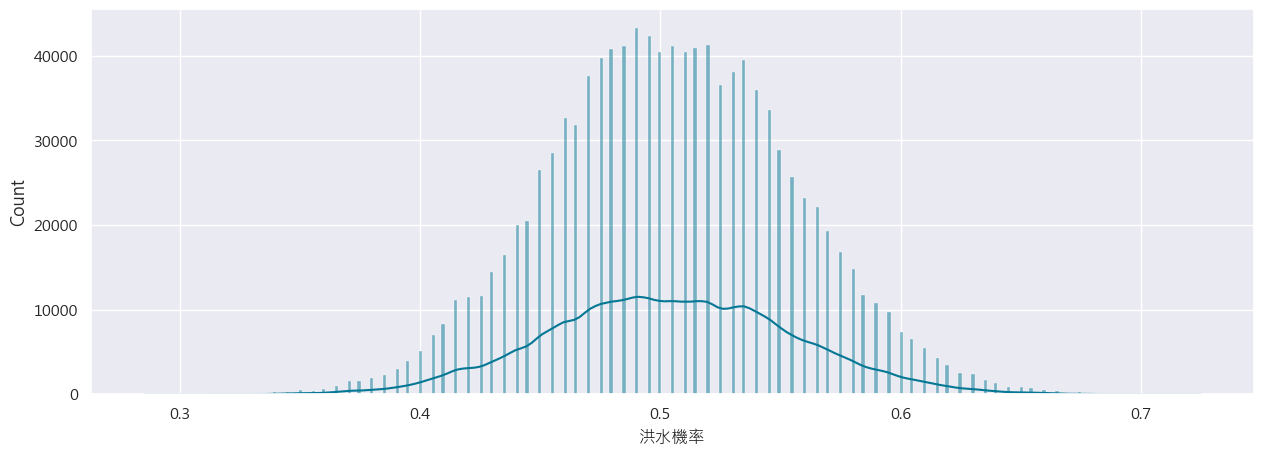

In [72]:
plt.rc('font', family = 'Microsoft JhengHei')
plt.figure(figsize=(15, 5))
sns.histplot(df_train['洪水機率'], color = '#047794', kde = True)

- 明顯所有特徵均是程度越高, 發生洪水的機率就越高
- 簡單來說, 地形破壞越嚴重, 災害就越嚴重

In [73]:
# # 觀察數值類型的特徵
# plt.rc('font', family = 'Microsoft JhengHei')
# plt.figure(figsize=(20,20))

# for col, source in enumerate(df_train):
#     if source == "洪水機率":
#         break
#     plt.subplot(5, 4, col+ 1)
    
#     # scatterplot
#     sns.scatterplot( x = source, y = "洪水機率", data = df_train, color = '#047794')

#     plt.tight_layout(h_pad = 3)
# plt.show()

#### 資料前處理

In [74]:
df_original = pd.read_csv('./data/Regression with a Flood Prediction Dataset/flood.csv')
train = pd.concat([df_train, df_original]).drop_duplicates()
test = df_test

# 使用StandardScaler對訓練數據進行標準化轉換
scaler = StandardScaler()
train_scaled = scaler.fit_transform(df_train.drop(columns = ['洪水機率']))
test_scaled = scaler.transform(df_test)

# 將標準化後的訓練數據轉換回DataFrame，以保留特徵名稱
train_scaled_df = pd.DataFrame(train_scaled, columns=df_train.drop(columns=['洪水機率']).columns)
test_scaled_df = pd.DataFrame(test_scaled, columns=df_test.columns)

X_train = train_scaled_df
y_train = df_train['洪水機率']
test = test_scaled_df

print(f'X_train.shape : {X_train.shape}')
print(f'y_train.shape : {y_train.shape}')
print(f'test.shape : {test.shape}')

X_train.shape : (1117957, 20)
y_train.shape : (1117957,)
test.shape : (745305, 20)


#### 建立模型

In [75]:
from lightgbm import LGBMRegressor

# 評分函數
scoring = {'r2': make_scorer(r2_score), 'mse': make_scorer(mean_squared_error)}

# 超參數
param_dist = {
    'max_depth': randint(5, 20),
    'learning_rate': uniform(0.01, 0.2),
    'n_estimators': randint(100, 1000)
}

lgb = LGBMRegressor()
random_search = RandomizedSearchCV(estimator = lgb, param_distributions = param_dist, scoring = scoring, refit = 'r2', n_iter = 10, cv = 20)
random_search.fit(X_train, y_train)

print("Best parameters found: ", random_search.best_params_)

y_train_predict = random_search.predict(X_train)

# 输出预测指标
print('LightGBM R2 score:', r2_score(y_train, y_train_predict))
print('LightGBM MSE:', mean_squared_error(y_train, y_train_predict))

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015471 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 370
[LightGBM] [Info] Number of data points in the train set: 894365, number of used features: 20
[LightGBM] [Info] Start training from score 0.504471
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leav

#### 預測並輸出結果

In [76]:
y_test_predict = random_search.predict(test)

sub = pd.read_csv('./data/Regression with a Flood Prediction Dataset/sample_submission.csv')
submission = pd.DataFrame()
submission['id'] = sub['id']
submission['FloodProbability'] = y_test_predict
submission.to_csv('./data/Regression with a Flood Prediction Dataset/submission_lgbm.csv', index = False)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
